# **Individual learning performances**

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils

import json

import os,sys
SUMO_HOME = os.environ["SUMO_HOME"] #locating the simulator
sys.path.append(SUMO_HOME+"/tools")
import sumolib

import tensorflow as tf
from tensorflow import keras

In [3]:
MEAS_PATH = "../dockeroutput/"
PARKING_AREA_DEFINITIONS = "../build_inputs/MoSTScenario/scenario/in/add/most.parking.add.xml"

In [4]:
parking_df = pd.read_xml(PARKING_AREA_DEFINITIONS)
parking_df = parking_df[parking_df["roadsideCapacity"]>0]

In [5]:
parking_df.head()

,id,lane,startPos,endPos,roadsideCapacity,friendlyPos,edges,interval
0,1059,-153419_1,10.000000,20.000000,225.0,true,None,NaN
1,1060,-152335_1,18.191499,28.191499,75.0,true,None,NaN
2,1061,153427#0_1,10.000000,20.000000,350.0,true,None,NaN
3,1062,-153427#5_1,10.583918,20.583918,350.0,true,None,NaN
4,1063,153547_1,37.879874,47.879874,50.0,true,None,NaN


In [27]:
VEHICLE_ID = 1225
#456#1225#307#3245

In [7]:
with open("../02_data/filtered_vehicles.json", "r") as f:
    vehicle_id_list= json.load(f)["vehicles"]
    
with open(MEAS_PATH+"day_0/edge_maps.json", "r") as f:
    edge_maps = json.load(f)
    idx_to_edge_map = edge_maps["idx_to_edge_map"]
    edge_to_idx_map = edge_maps["edge_to_idx_map"]
    
with open(MEAS_PATH+"day_0/vehicle_maps.json", "r") as f:
    veh_maps = json.load(f)
    vehicle_to_idx_map = veh_maps["vehicle_to_idx_map"]
    idx_to_vehicle_map = veh_maps["idx_to_vehicle_map"]

In [23]:
vehicle_id = vehicle_id_list[VEHICLE_ID]
vehicle_idx = vehicle_to_idx_map[vehicle_id]

## Plotting vehicle's knowledge

In [33]:
nominal_vehicle_data = pd.read_csv(MEAS_PATH+"day_0/vehicle_measurement.csv")

In [34]:
#nominal_vehicle_data = nominal_vehicle_data[nominal_vehicle_data["veh_id"] == vehicle_id]
nominal_vehicle_data = nominal_vehicle_data[nominal_vehicle_data["veh_id"] == "commercial_3-1_98"]

In [35]:
nominal_vehicle_data.head()

,veh_id,day,timestamp,parking_id,occupancy
13483934,commercial_3-1_98,0,37820,1087,0.0
13498233,commercial_3-1_98,0,37830,1087,0.0
13512573,commercial_3-1_98,0,37840,1087,0.0
13526933,commercial_3-1_98,0,37850,1087,0.0
13541289,commercial_3-1_98,0,37860,1087,0.0


In [11]:
known_edges = []
for pid in nominal_vehicle_data["parking_id"].unique():
    p_lot = parking_df[parking_df["id"] == pid]
    known_edges.append(str(edge_to_idx_map[p_lot.iloc[0]["lane"].split("_")[0]]))

In [12]:
net = sumolib.net.readNet("../build_inputs/MoSTScenario/scenario/in/most.net.xml")

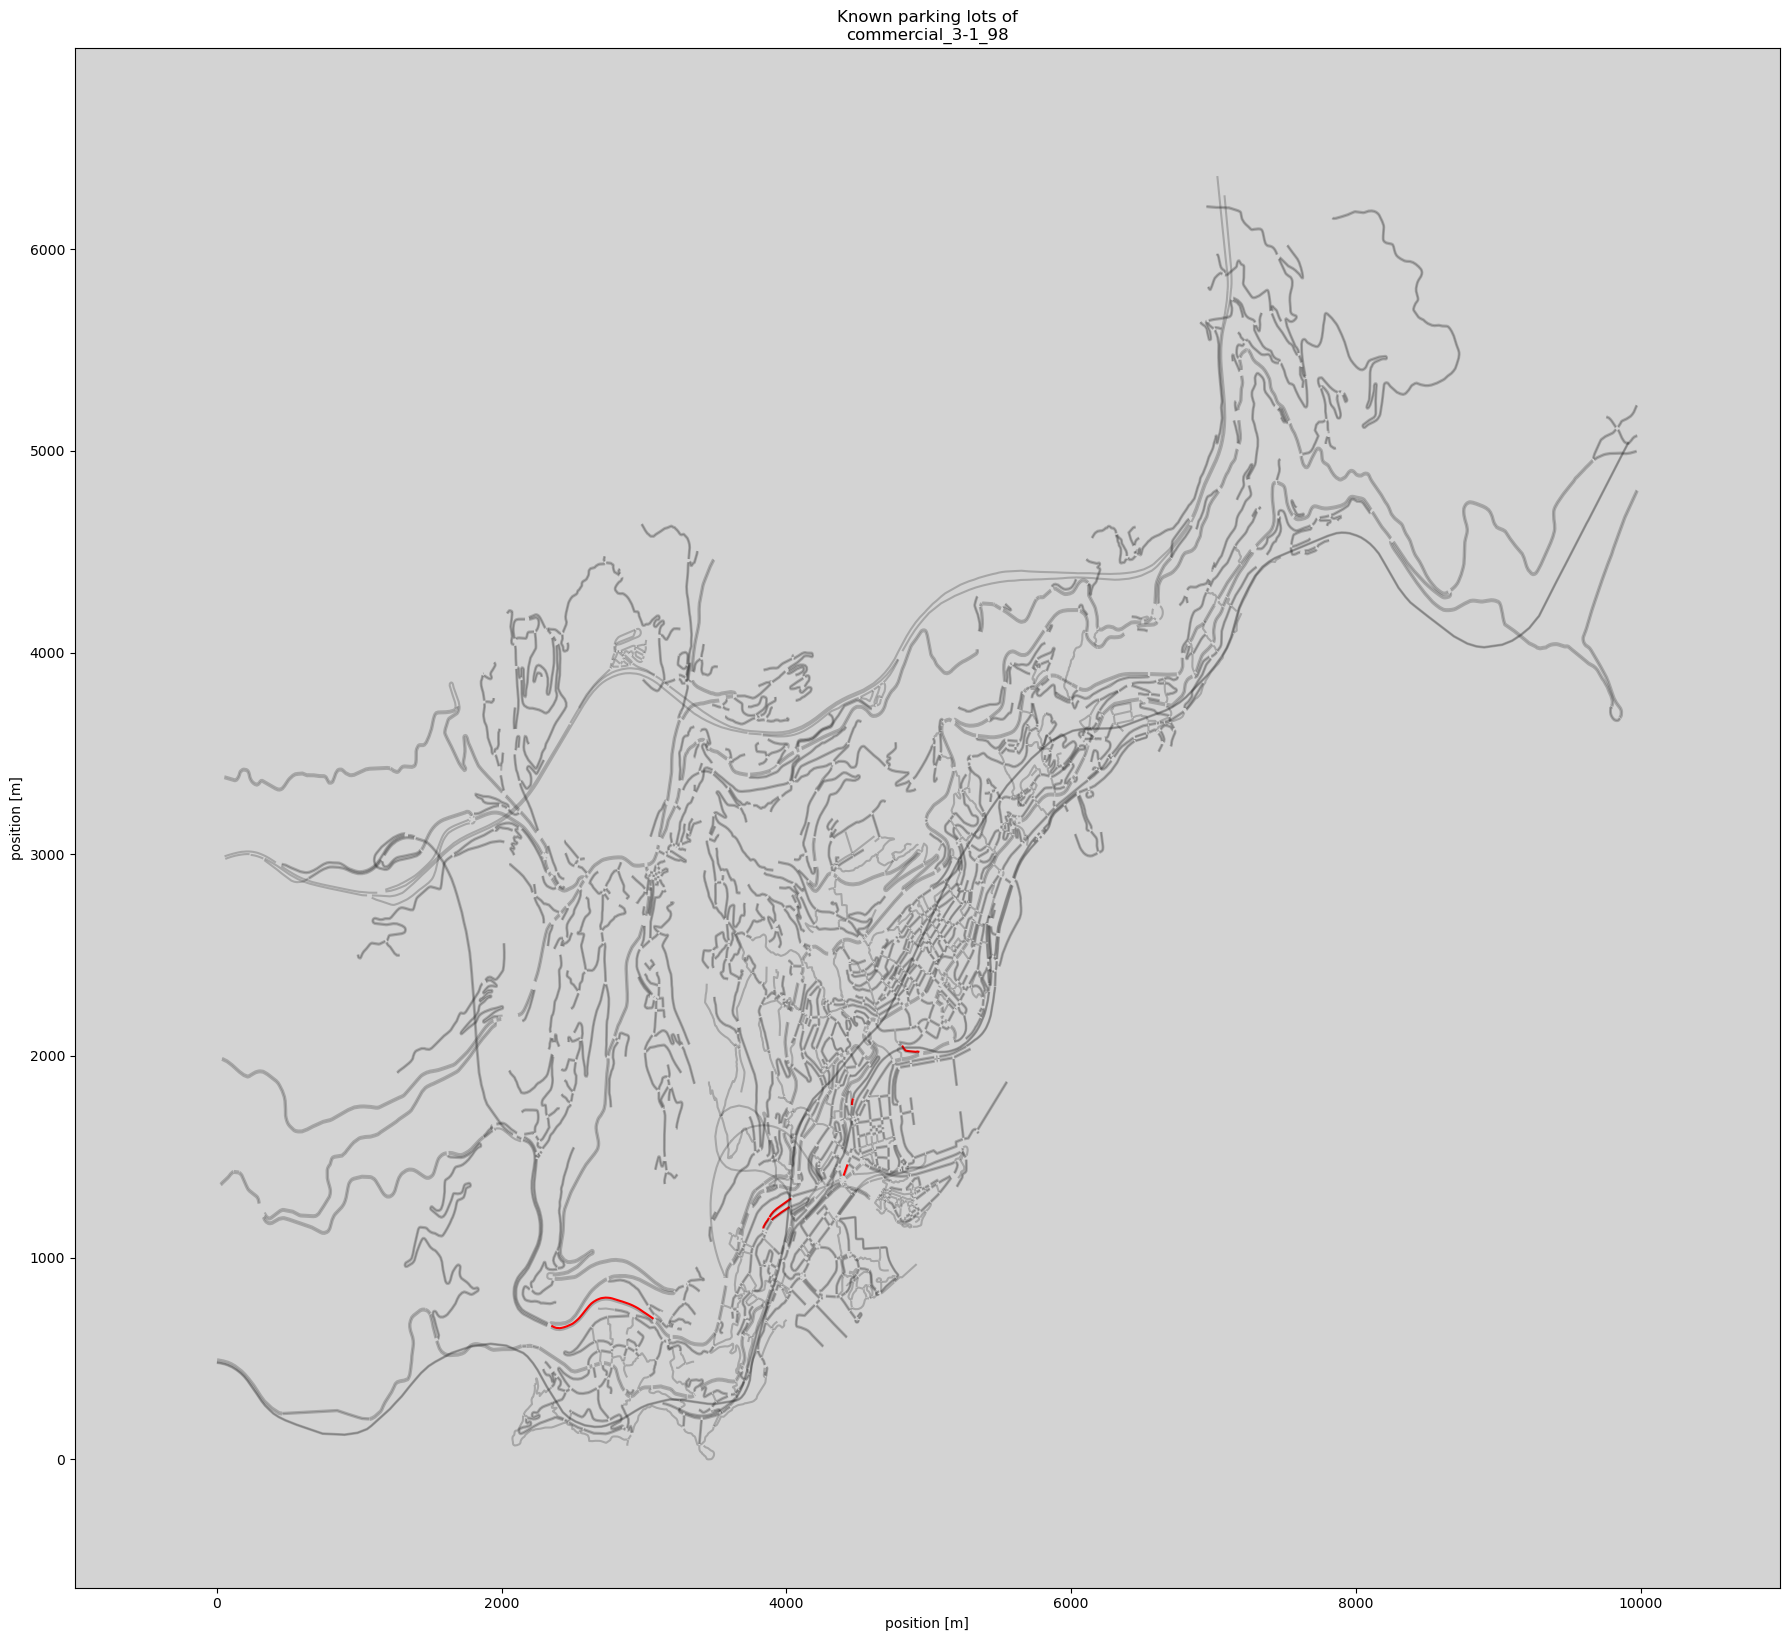

In [13]:
fig, ax = utils.plot_network_probs(net, None, idx_to_edge_map, title="Known parking lots of\n%s"%vehicle_id,
                             special_edges=known_edges)
plt.savefig("../05_doc/img/known_lots_%s.png"%vehicle_id)
fig.show()

## **Learning of an individual vehicle**

In [9]:
EPOCHS = 100
TRAIN = range(0, 55)
TEST = range(55, 60)

In [10]:
import neural_network

In [ ]:
#loading training dataset:
train_data = None

for i in TRAIN:
    td = pd.read_csv(MEAS_PATH+"day_%d/nn.csv"%i, header=None)
    td[129] = td[129].astype(int)
    td = td[td[129] == vehicle_idx]
    
    if train_data is None:
        train_data = td
    else:
        train_data = pd.concat([train_data, td])

In [ ]:
train_data = np.array(train_data.sample(frac=1.0))

In [12]:
nn = neural_network.NeuralNetwork()

2023-02-05 18:02:32.229917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 18:02:32.232617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 18:02:32.232746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 18:02:32.233482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [19]:
train_data.shape

(766, 131)

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=3)
history = nn.model.fit(train_data[:,:-2],
                       train_data[:,-1], batch_size=1000, epochs=EPOCHS, validation_split=.3,
                       callbacks=[callback])

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 2.0307 - val_loss: 1.7896
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 1.8241 - val_loss: 1.6180
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 1.6467 - val_loss: 1.4707
Epoch 4/100
1/1 [==============================] - 0s 18ms/step - loss: 1.4956 - val_loss: 1.3191
Epoch 5/100
1/1 [==============================] - 0s 19ms/step - loss: 1.3408 - val_loss: 1.1662
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 1.1841

2023-01-27 17:02:45.700196: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 19ms/step - loss: 1.1841 - val_loss: 1.0204
Epoch 7/100
1/1 [==============================] - 0s 18ms/step - loss: 1.0355 - val_loss: 0.8766
Epoch 8/100
1/1 [==============================] - 0s 18ms/step - loss: 0.8894 - val_loss: 0.7521
Epoch 9/100
1/1 [==============================] - 0s 18ms/step - loss: 0.7612 - val_loss: 0.6254
Epoch 10/100
1/1 [==============================] - 0s 19ms/step - loss: 0.6338 - val_loss: 0.5066
Epoch 11/100
1/1 [==============================] - 0s 18ms/step - loss: 0.5116 - val_loss: 0.4090
Epoch 12/100
1/1 [==============================] - 0s 20ms/step - loss: 0.4123 - val_loss: 0.3239
Epoch 13/100
1/1 [==============================] - 0s 14ms/step - loss: 0.3256 - val_loss: 0.2406
Epoch 14/100
1/1 [==============================] - 0s 17ms/step - loss: 0.2416 - val_loss: 0.1783
Epoch 15/100
1/1 [==============================] - 0s 16ms/step - loss: 0.1781 - val_loss: 0.1245
Epoch 16/100
1/1 [========

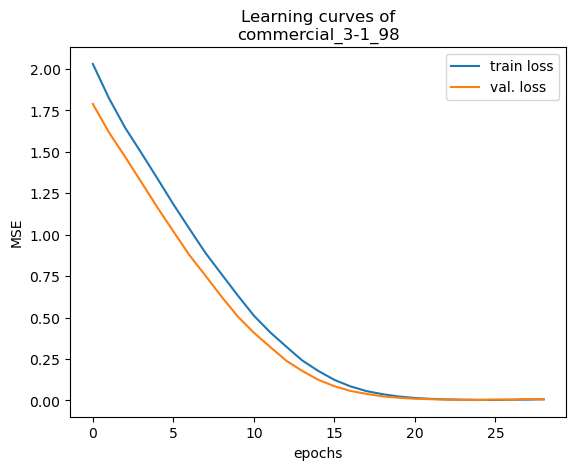

In [21]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val. loss")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("Learning curves of\n%s"%vehicle_id)
plt.savefig("../05_doc/img/ind_lc_%s.png"%vehicle_id)

In [22]:
nn.model.save("../04_nn_models/ind_%s"%vehicle_id)

INFO:tensorflow:Assets written to: ../04_nn_models/ind_commercial_3-1_98/assets


### Testing

In [14]:
nn.model = keras.models.load_model("../04_nn_models/ind_commercial_3-1_98/")

In [15]:
#constants for normalizing/standardizing:
parking_df = parking_df.set_index(["id"])
nominals = pd.read_csv(MEAS_PATH+"day_0/occupancies.csv")
perc_ = []
for i,r in nominals.iterrows():
    perc_.append(r.counts/parking_df.loc[r.ids]["roadsideCapacity"])
nominals["percentage"] = perc_

In [16]:
PARKING_ID_LIST = [i for i in range(1059, 1186+1)]

In [17]:
MIN_T = 18150
MAX_T = 46800
MEAN = 0.59
STD = 0.35302

In [52]:
def draw_parking(parking_id, nn, title=None, filename=None):
    test_t = np.arange(14400, 50400, 60)
    test_t = utils.normalize(test_t, MIN_T, MAX_T)

    id_encoding = utils.one_hot_encoder([parking_id]*len(test_t), PARKING_ID_LIST)
    #print(id_encoding.shape)

    test_d = np.hstack([id_encoding, test_t.reshape(len(test_t), 1)])
    #print(test_d.shape)

    output = nn.model.predict(test_d)
    output = utils.de_standardize(output, MEAN, STD)
    
    p_lot = nominals[nominals["ids"] == parking_id]
    p_lot_occup = p_lot.groupby("timestamp")["percentage"].mean()
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(p_lot_occup.index/(60*60), p_lot_occup, label="measured (day0)")
    ax.plot(p_lot_occup.index/(60*60), output, "--", label="estimated")
    ax.set_xlabel("time [h]")
    ax.set_ylabel("occupied [vehicles]")
    ax.legend(loc=3)
    ax.set_title(title)
    ax.set_ylim(-0.15, 1.15)
    if not(filename is None):
        plt.savefig(filename)
    return fig, ax

#### Known parking lot

In [36]:
moving_time = [nominal_vehicle_data.timestamp.min()/3600, nominal_vehicle_data.timestamp.max()/3600]
moving_time

[10.505555555555556, 10.633333333333333]

In [37]:
nominal_vehicle_data

,veh_id,day,timestamp,parking_id,occupancy
13483934,commercial_3-1_98,0,37820,1087,0.000
13498233,commercial_3-1_98,0,37830,1087,0.000
13512573,commercial_3-1_98,0,37840,1087,0.000
13526933,commercial_3-1_98,0,37850,1087,0.000
13541289,commercial_3-1_98,0,37860,1087,0.000
13555642,commercial_3-1_98,0,37870,1087,0.000
13570012,commercial_3-1_98,0,37880,1087,0.000
13584374,commercial_3-1_98,0,37890,1087,0.000
13829796,commercial_3-1_98,0,38060,1140,1.000
13829797,commercial_3-1_98,0,38060,1178,0.012


In [38]:
known_lots = nominal_vehicle_data["parking_id"].unique()
known_lots

array([1087, 1140, 1178, 1139, 1111, 1123, 1145, 1147])

In [39]:
lot = 1140

19/19 [==============================] - 0s 812us/step


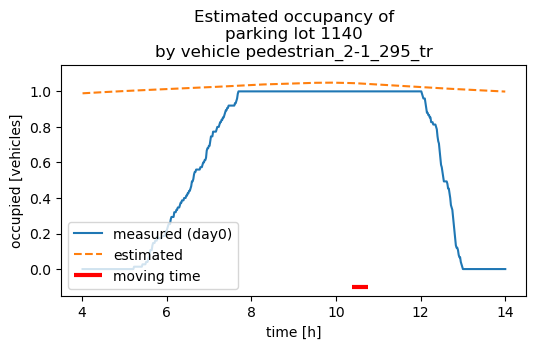

In [53]:
fig, ax = draw_parking(lot, nn,
             "Estimated occupancy of\nparking lot %d\nby vehicle %s"%(lot, vehicle_id))
ax.hlines(y=-0.1, xmin=moving_time[0]-.125, xmax=moving_time[1]+.125,
           color="r", linewidth=3, label="moving time", ls="-")
ax.legend(loc=3)
fig.show()
plt.savefig("../05_doc/img/estim_ind_%d_%s"%(lot, vehicle_id))

#### Unkown parking lot

In [54]:
lot = 1101

19/19 [==============================] - 0s 917us/step


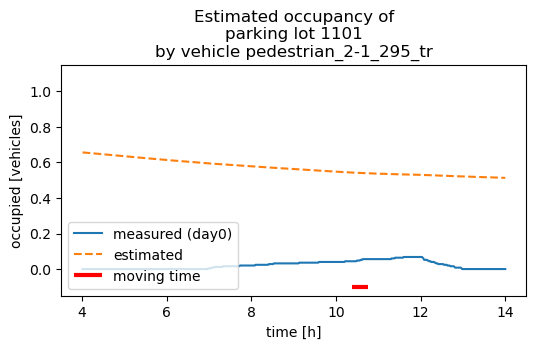

In [55]:
fig, ax = draw_parking(lot, nn,
             "Estimated occupancy of\nparking lot %d\nby vehicle %s"%(lot, vehicle_id))
ax.hlines(y=-0.1, xmin=moving_time[0]-.125, xmax=moving_time[1]+.125,
           color="r", linewidth=3, label="moving time", ls="-")
ax.legend(loc=3)
fig.show()
plt.savefig("../05_doc/img/estim_ind_%d_%s"%(lot, vehicle_id))